### Fitting data to a regression or classification problem can be problematic for 3 main reasons:
### **1. Multicollinearity:** when two or more features are correlated (e.g. linearly dependent) matrix X becomes singular and causes calculation/convergence problems and the problem is considered ill-defined [check linear algebra for definition of a singular matrix](https://www.onlinemathlearning.com/singular-matrix.html#:~:text=A%20singular%20matrix%20is%20one%20which%20is%20non-invertible,and%20only%20if%20its%20determinant%20is%20zero.%20Example%3A)
### **2. Overfitting:** overfitting practically means that we fit an unnecessary complex model to the data and as a results we will fail to predict future observations accurately (think of fitting a 3rd order polynomial in the Beer's Law example!!!). 
### **3. Interpretation:** is tightly linked to the complexity of the model. A complex model is not only a model that is of higher order (let's say 3rd order polynomial compared with a linear 1st order model). If you fit a model to 1000 genes expression in human cells with a logistic regression to identify cancer indicators, **all** genes coefficients will be non-zero, some very high, other lower. What do you tell the doctors? The doctors need you to identify a small number of genes (2-5) to target for cancer therapy. Therefore, you need a method to **force** the majority of the coefficients to zero (or very small values).
### The answer to this problem is **REGULARIZATION**. With this method we apply a penalty or cost term in the objective function of the optimization problem (e.g. least squares). <br> Following the notation in [Sklearn documentation](https://scikit-learn.org/stable/modules/linear_model.html#ridge-regression-and-classification), in the Ordinary Least Squares the objective function is $\min_{w}\|Xw-y\|_2^2$, i.e. minimize the square of error by changing the coefficients w. <br> With regularization, we add a penalty/cost term for the coefficients **w**. The two most common forms are: $\min_{w}\|Xw-y\|_2^2 + \alpha\|w\|_2^2$ (Ridge or $l_2$-norm) and $\min_{w}\|Xw-y\|_2^2 + \alpha\|w\|_1$ (LASSO or $l_1$-norm). <br> Practically, every time a coefficient gets a high value the objective function increases. As a result, the optimization will seek to reduce or even turn to zero the values of the coefficients w, resulting in a sparse solution (i.e. few non-zero coefficients w). 
### Parameter $\alpha$ controls the regularization strength. The larger the $\alpha$ the higher the penalty in the minimization function, and more coefficients will be forced to zero, leading to simpler more interpretable models. 
### The idea of regularization is very general and is applied in pretty much all models in Sklearn. Parameter C we saw earlier is actually the inverse of $\alpha$. In this notebook, we will apply and explore the idea of regularization to the Credit Card data.

In [1]:
# Import libraries and settings
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from matplotlib.ticker import MaxNLocator
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (8, 8)
matplotlib.rcParams.update({'font.size': 16})
import seaborn as sns

In [2]:
# Import data and rename column
cc_data = pd.read_excel('cc_data_uci.xls')
cc_data.rename(columns={'default payment next month': 'OUTPUT'}, inplace = True)

# Separate inputs: X and output:y
X = cc_data.drop(['OUTPUT'], axis = 1)
y = cc_data['OUTPUT']

cc_data.head(5)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,OUTPUT
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [3]:
# Create the instance of the scaler
scaler = StandardScaler()
# Transform the inputs X
X_scaled = scaler.fit_transform(X)

In [4]:
# Split in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=2/3, random_state=0)

### Just like the LogReg tutorial, we imported the data, scaled them and split them in train-test sets.
### Next, we will apply the Logistic Regression again, but this time in a **for loop** with changing values of C, in order to understand what the effect of changing C values is and how to choose one appropriately.

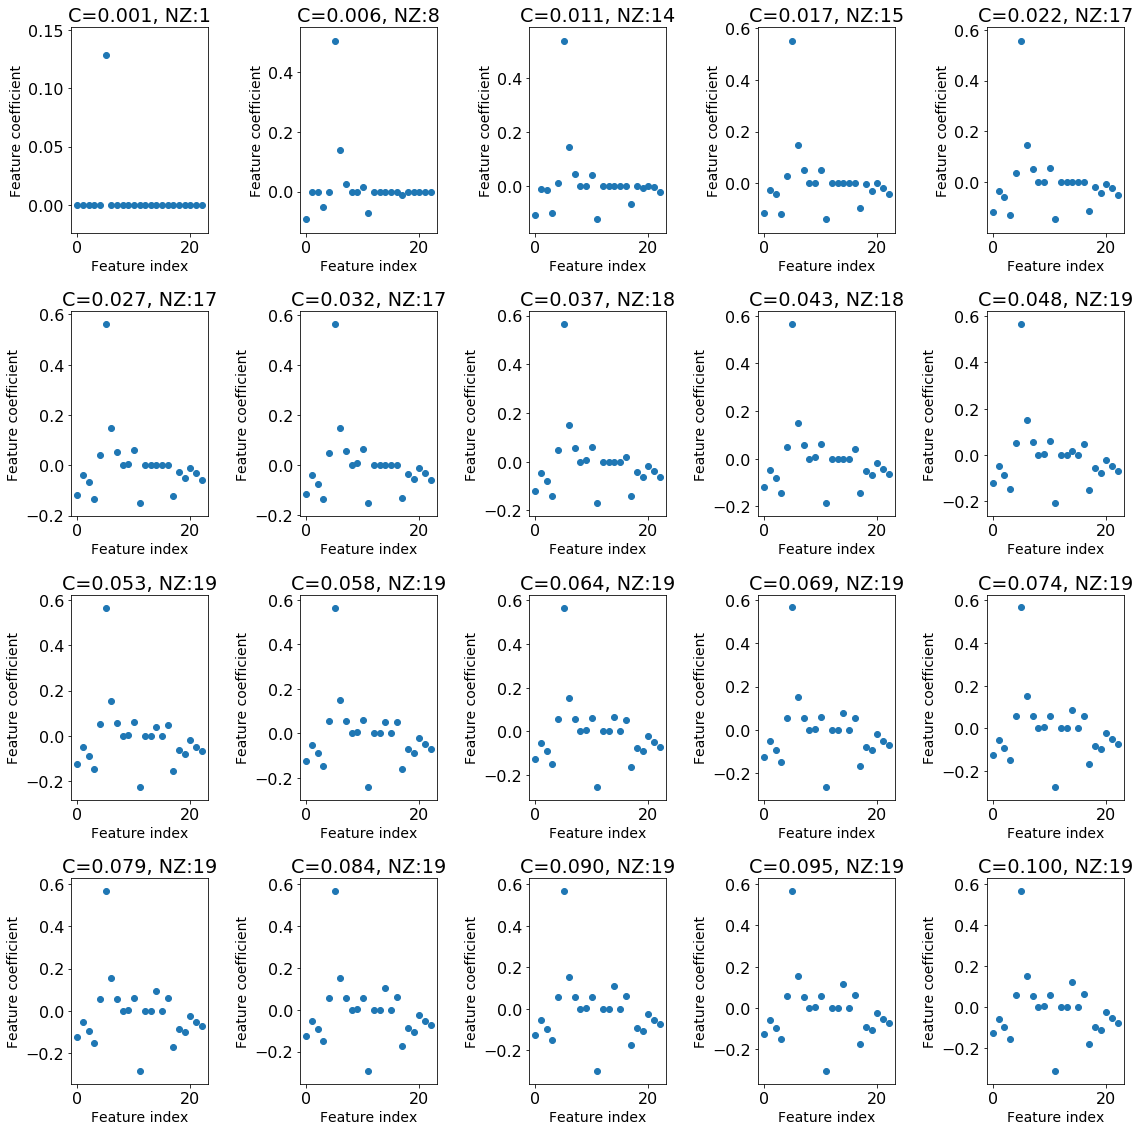

In [5]:
# ===================================== #
# === [Sklearn Model Configuration] === #
# ===================================== #

C = np.linspace(0.001, 0.1, 20)
# Smaller values, stronger regularization, more coefficients will go to zero

# Initialize the variables you want to save in an iterative manner
count                     = -1
Train_AUC_iter_LR         = np.zeros(shape=(len(C),1))
Test_AUC_iter_LR          = np.zeros(shape=(len(C),1))
NonZeroCoeff_LR           = np.zeros(shape=(len(C),1))
Model_Coeff_LR            = np.zeros(shape=(X.shape[1], len(C)))

fig = plt.figure(figsize=(16, 16))

for c in C:
    count += 1
    # instantiate a logistic regression model, and fit with X and y
    model_LR = LogisticRegression(C=c, penalty='l1', solver="liblinear")
    # Fit the model
    model_LR.fit(X_train, y_train)
    Model_Coeff_LR[:,count] = model_LR.coef_[0,:]
    # Scores for train set
    scores_train_LR = model_LR.predict_proba(X_train)[:, 1]
    # Scores for test set
    scores_test_LR = model_LR.predict_proba(X_test)[:, 1]
    
    # ============================ #
    # === [Train: ROC and AUC] === #
    # ============================ #
    # ROC Calc
    fpr_train_LR, tpr_train_LR, _ = roc_curve(y_train, scores_train_LR)
    # AUC Calc
    auc_train_LR = auc(fpr_train_LR, tpr_train_LR)
    Train_AUC_iter_LR[count,0] = auc_train_LR
    # ============================ #
    # === [Test: ROC and AUC] === #
    # ============================ #
    # ROC Calc
    fpr_test_LR, tpr_test_LR, _ = roc_curve(y_test, scores_test_LR)
    # AUC Calc
    auc_test_LR = auc(fpr_test_LR, tpr_test_LR)
    Test_AUC_iter_LR[count,0] = auc_test_LR
    ### Extract the count of non-zero coefficients
    NonZeroCoeff_LR[count,0] = X.shape[1] - (model_LR.coef_ == 0).sum()
    
    x = model_LR.coef_.transpose()   
    index = np.arange(len(x))  
    
    ax = fig.add_subplot(4,5,count+1)
    ax.scatter(index, x)
    ax.set_title('C=%.3f, NZ:%s' %(c,X.shape[1]-(model_LR.coef_ == 0).sum()))
    ax.set_xlabel('Feature index', fontsize = 14)
    ax.set_ylabel('Feature coefficient', fontsize = 14)
plt.tight_layout()    
plt.show()


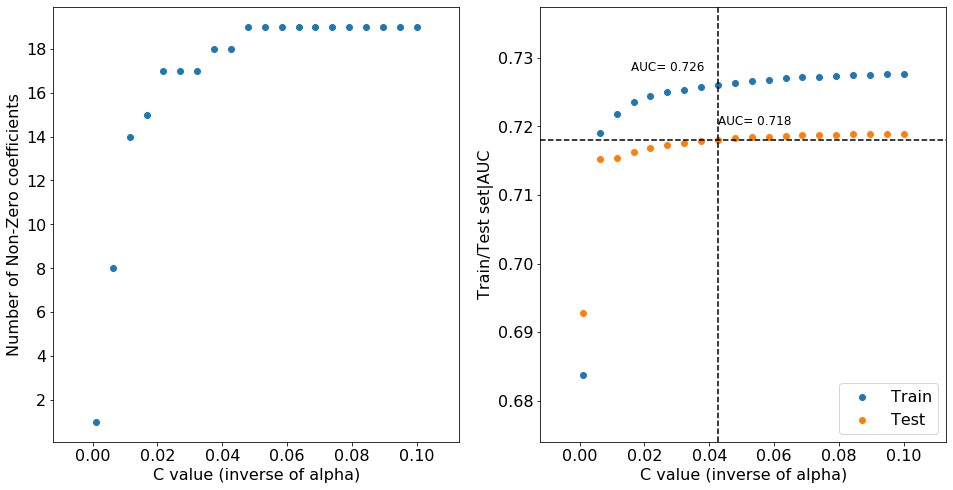

In [6]:
# Plot of the NonZero coefficients    
fig = plt.figure(figsize=(16, 8))
sub1 = fig.add_subplot(121)
plt.scatter(C, NonZeroCoeff_LR)
sub1.set_ylabel('Number of Non-Zero coefficients')
sub1.set_xlabel('C value (inverse of alpha)')
sub1.yaxis.set_major_locator(MaxNLocator(integer=True))
# sub1.set_xlim(0.01,1)
# plt.xscale('log')
# plt.show()

sub2 = fig.add_subplot(122)
plt.scatter(C,Train_AUC_iter_LR)
plt.scatter(C,Test_AUC_iter_LR)
sub2.set_xlabel('C value (inverse of alpha)')
sub2.set_ylabel('Train/Test set|AUC')
# sub1.set_xlim(0.02,0.06)
plt.annotate('AUC= %0.3f' %(Test_AUC_iter_LR[8]), xy=(C[8], 1.003*Test_AUC_iter_LR[8]), xycoords='data',horizontalalignment= 'left', fontsize = 12)
plt.annotate('AUC= %0.3f' %(Train_AUC_iter_LR[8]), xy=(0.9*C[8], 1.003*Train_AUC_iter_LR[8]), xycoords='data',horizontalalignment= 'right', fontsize = 12)
plt.legend(['Train','Test'], loc ='lower right')
plt.axhline(Test_AUC_iter_LR[8], color = 'k', linestyle = '--')
plt.axvline(C[8], color = 'k', linestyle = '--')
# plt.plot([C[8],C[8]],[plt.ylim()[0],Test_AUC_iter_LR[8]])
# plt.xscale('log')

plt.show()